## Dataset

#### Loading

In [ ]:
from google.colab import drive
import pandas as pd

In [ ]:
drive.mount('/content/drive')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Chezlong/Data/nafsy.csv')

In [ ]:
len(df)

664

In [ ]:
# Keeping content only
data = df[['content']]

#### Exploratory Text Analysis

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data['text_size'] = data['content'].apply(len)

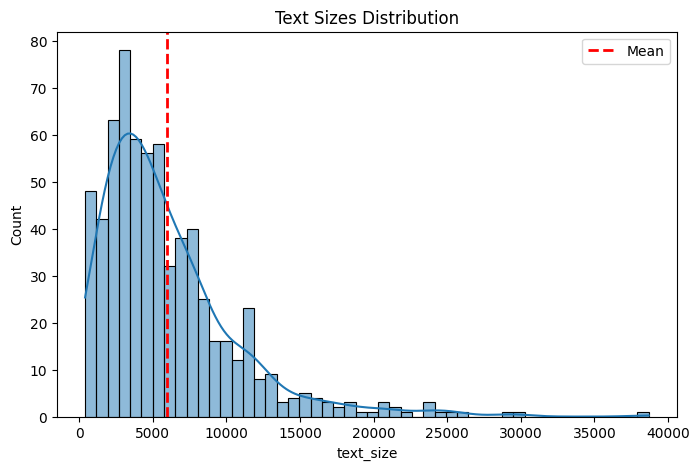

In [ ]:
# Plot distribution of size
plt.figure(figsize=(8,5))
sns.histplot(data['text_size'], bins=50, kde=True)
plt.axvline(data['text_size'].mean(), color='r', linestyle='dashed', label='Mean', linewidth=2)
plt.legend()
plt.title("Text Sizes Distribution")
plt.show()

In [ ]:
data['text_size'].describe()

count      664.00000
mean      5967.48494
std       4739.42948
min        398.00000
25%       2819.00000
50%       4745.50000
75%       7719.25000
max      38696.00000
Name: text_size, dtype: float64

#### Splitting Text Into Smaller Chunks

In [ ]:
!pip install -qU langchain tiktoken

In [ ]:
from langchain.text_splitter import TokenTextSplitter

In [ ]:
text_splitter = TokenTextSplitter(chunk_size=2048, chunk_overlap=20)

In [ ]:
# Create a new dataframe with a smaller chunks

splitted_data = {'content':[]}

for example in data['content']:
  splitted_data["content"] += text_splitter.split_text(example)

splitted_data = pd.DataFrame(splitted_data)

In [ ]:
splitted_data['text_size'] = splitted_data['content'].apply(len)

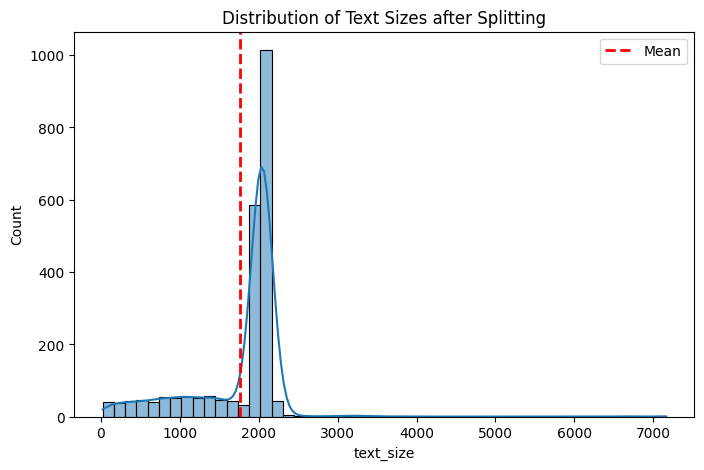

In [ ]:
# Plot distribution of size after splitting
plt.figure(figsize=(8,5))
sns.histplot(splitted_data['text_size'], bins=50, kde=True)
plt.axvline(splitted_data['text_size'].mean(), color='r', linestyle='dashed', label='Mean', linewidth=2)
plt.legend()
plt.title("Distribution of Text Sizes after Splitting")
plt.show()

In [ ]:
# Shuffling data
splitted_data = splitted_data.sample(frac=1, random_state=5)

In [ ]:
splitted_data['text_size'].describe()

count    2260.000000
mean     1767.492920
std       574.263426
min        22.000000
25%      1723.250000
50%      2015.000000
75%      2067.000000
max      7164.000000
Name: text_size, dtype: float64

#### Cleaning
- Reduces unnecessary variation

In [ ]:
import re
import random
import nltk
nltk.download('punkt') # To include and use word tokenizer
from nltk.tokenize import word_tokenize

In [ ]:
def clean_text(text:str):
  # check whether text is of type string
  if not isinstance(text, str):
    raise TypeError("TypeError: text must be a string")

  # remove urls
  text = re.sub(r"\bhttps?://\S+", "رابط", text)

  # remove numbers
  # text = re.sub(r"\d+", "رقم", text)

  # Detach punctuations
  text = re.sub(r"([^\w\s])", r" \1 ", text)

  # remove extra spaces
  text = re.sub(r"\s+", " ", text)

  # This part to make sure of good cleaning (may take long execution time)
  words = word_tokenize(text)
  text = " ".join([w for w in words if len(w)>1]) # remove non words

  text = text.lower() # for English words

  return text.strip()

def normalize_text(text:str):
  # normalize alif
  text = text.replace(u"\u0625", u"\u0627")  # HAMZA below, with LETTER ALEF
  text = text.replace(u"\u0622", u"\u0627")  # ALEF WITH MADDA ABOVE, with LETTER ALEF
  text = text.replace(u"\u0623", u"\u0627")  # ALEF WITH HAMZA ABOVE, with LETTER ALEF

  # normalize taa
  text = text.replace(u"\u0629", u"\u0647") # taa' marbuuTa, with haa'

  # normalize yaa
  text = text.replace(u"\u064A", u"\u0649")  # yaa' with 'alif maqSuura

  # remove diacritics
  text = text.replace(u"\u064B", "")  # fatHatayn
  text = text.replace(u"\u064C", "")  # Dammatayn
  text = text.replace(u"\u064D", "")  # kasratayn
  text = text.replace(u"\u064E", "")  # fatHa
  text = text.replace(u"\u064F", "")  # Damma
  text = text.replace(u"\u0650", "")  # kasra
  text = text.replace(u"\u0651", "")  # shaddah
  text = text.replace(u"\u0652", "")  # sukuun
  text = text.replace(u"\u0670", "`")  # dagger 'alif

  return text

In [ ]:
splitted_data['content'] = splitted_data['content'].apply(clean_text)

In [ ]:
# Remove repeated documents
splitted_data.drop_duplicates(inplace=True)
print(len(splitted_data))

2216


## Exploratory Text Analysis with BERTopic

In [ ]:
!pip install bertopic==0.16.0

#### Embed Articles

In [ ]:
from sentence_transformers import SentenceTransformer
import pickle

In [ ]:
model_id = "asafaya/bert-base-arabic"
embedding_model = SentenceTransformer(model_id, device="cuda:0")

In [ ]:
# articles_embeddings = embedding_model.encode(splitted_data["content"].values, show_progress_bar=True)
# print(articles_embeddings.shape)

In [ ]:
# # Store data and embeddings
# with open("bertarabic_embeddings_splitted.pkl", "wb") as fOut:
#   pickle.dump({'embeddings': articles_embeddings},
#               fOut,
#               protocol = pickle.HIGHEST_PROTOCOL)

In [ ]:
# # Load data and embeddings
with open("/content/drive/MyDrive/Colab Notebooks/Chezlong/Topic Modeling/bertarabic_embeddings_splitted.pkl", 'rb') as fIn:
  articles_embeddings = pickle.load(fIn)['embeddings']

#### Dimensionality Reduction

In [ ]:
from umap import UMAP

In [ ]:
umap_model = UMAP(
    n_neighbors = 7,
    n_components = 45,
    min_dist = 0,
    metric = "cosine",
    random_state = 5
)

#### Clustering

In [ ]:
from hdbscan import HDBSCAN

In [ ]:
hdbscan_model = HDBSCAN(
    min_cluster_size = 3,
    metric = "euclidean",
    cluster_selection_method = "eom",
    prediction_data = True
)
# A high min_cluster_size will generate fewer topics
# A low min_cluster_size will generate more topics
# Prediction_data=True -> allows for predicting the cluster membership of new data points based on the trained model
# HDBSCAN can be used to tune outliers

#### Vectorizer
- Traditional method to represent text
- Words appear in which documents?
- Helps in:
  - Seperating words in text (word representation)
  - Giving labels/titles for topics

In [ ]:
!pip install Arabic-Stopwords==0.4.3

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import arabicstopwords.arabicstopwords as stp

In [ ]:
stop_words = stp.stopwords_list()
stop_words.extend( list(map(normalize_text, stp.stopwords_list())) )

vectorizer_model = CountVectorizer(min_df = 3,
                                   stop_words = stop_words,
                                   analyzer = 'word',
                                   max_df = 100,
                                   ngram_range = (1, 3)
                                   )
# min_df to ignore words that appeared in 3 documents or less as they might be noise
# max_df to ignore words that appeared in 100 documents or more (treated as stop words)

## BERTopic



#### Topic Representer

In [ ]:
from bertopic.representation import KeyBERTInspired

In [ ]:
topicRep_model = {"KeyBERT":KeyBERTInspired()}

#### BERTopic Model

In [ ]:
from bertopic import BERTopic

In [ ]:
topic_model = BERTopic(
    # Pipeline models
    embedding_model = embedding_model,
    umap_model = umap_model,
    hdbscan_model = hdbscan_model,
    vectorizer_model = vectorizer_model,
    representation_model = topicRep_model,

    # Hyperparameters
    top_n_words = 10, # For each topic, the top 10 most representative words will be selected
    verbose = True # Info about and while training
)

In [ ]:
# Load saved model
# topic_model = BERTopic.load("/content/drive/MyDrive/Colab Notebooks/Chezlong")

#### Training

In [ ]:
topics, probs = topic_model.fit_transform(
    splitted_data['content'],
    articles_embeddings
)

In [ ]:
# Save the model
# topic_model.save("/content/drive/MyDrive/Colab Notebooks/Chezlong",
#                  serialization="safetensors",
#                  save_ctfidf=True
#                  )

In [ ]:
# Generate labels
topic_labels = topic_model.generate_topic_labels(nr_words=10, topic_prefix=False, word_length=15, separator='-')
topic_model.set_topic_labels(topic_labels)

In [ ]:
topic_info = topic_model.get_topic_info()

In [ ]:
topic_info

,Topic,Count,Name,CustomName,Representation,KeyBERT,Representative_Docs
0,-1,385,-1_الطفل_الآخر_التدخين_المريض,الطفل-الآخر-التدخين-المريض-الأسرة-القلق-العلاج...,"[الطفل, الآخر, التدخين, المريض, الأسرة, القلق,...","[الرهاب الاجتماعي, الاضطراب, الغضب, فقال, الره...",[الخجل والحياء والجراءة طرفان لسمة واحدة من سم...
1,0,314,0_الطفل_العلاج_الأدوية_الأسرة,الطفل-العلاج-الأدوية-الأسرة-شيء-الخوف-الشخصية-...,"[الطفل, العلاج, الأدوية, الأسرة, شيء, الخوف, ا...","[السلوك, الزوج, العادة, الخوف, الوالدين, يشعر,...",[هور حالتهم وتزداد شدة بعض المرضى يلجأ للانتحا...
2,1,36,1_العلاج_العلاج النفسي_المعرفي_العلاج المعرفي,العلاج-العلاج النفسي-المعرفي-العلاج المعرفي-ال...,"[العلاج, العلاج النفسي, المعرفي, العلاج المعرف...","[العلاج السلوكي المعرفي, العلاج المعرفي السلوك...",[باب النفسية التي قد تكون نتاج أسباب تربوية وع...
3,2,34,2_التنشئة_التنشئة الاجتماعية_الاجتماعية_الاجتماعي,التنشئة-التنشئة الاجتما-الاجتماعية-الاجتماعي-ا...,"[التنشئة, التنشئة الاجتماعية, الاجتماعية, الاج...","[عملية التنشئة الاجتماعية, سلوك الفرد, النضج ا...",[رية المقررة والمقبولة اجتماعيا بما يعزز ثقتهم...
4,3,28,3_الأم_الانفعالى_الاجتماعى_الطفل,الأم-الانفعالى-الاجتماعى-الطفل-الرضيع-الدوافع-...,"[الأم, الانفعالى, الاجتماعى, الطفل, الرضيع, ال...","[النمو الانفعالى, الانفعالى, الدافع, الغضب, ال...",[العمر ويؤدى إلى زيادة التطبيع الاجتماعى فى نف...
...,...,...,...,...,...,...,...
182,181,4,181_موسى_معتز_الكهف_الرحمة,موسى-معتز-الكهف-الرحمة-موسى السلام-السلام-يا-ع...,"[موسى, معتز, الكهف, الرحمة, موسى السلام, السلا...","[عمران 159, والراحة النفسية, موسى السلام, قال ...",[ور النتيجة كان معتز متخوف واضع يده على قلبه إ...
183,182,4,182_استرخ_يديك_قدميك_فمك,استرخ-يديك-قدميك-فمك-ارفع-حسنا-رأسك-عضلات-جسمك...,"[استرخ, يديك, قدميك, فمك, ارفع, حسنا, رأسك, عض...","[الاسترخاء العضلي, القدمين, بالاسترخاء, كرسي م...",[يعتبر رهاب الساح مشكلة معيقة عند البعض تتسم ب...
184,183,3,183_النظافة_الغسل_لدرجة_القهرية,النظافة-الغسل-لدرجة-القهرية-تغسل-بالشك-الطقوس-...,"[النظافة, الغسل, لدرجة, القهرية, تغسل, بالشك, ...","[تسير الأمور, الوساوس القهرية, باضطراب الوسواس...",[ير من الزوجة بما يؤثر على واجباتها المنزلية و...
185,184,3,184_الاتصال الاجتماعي_الاتصال_اللاإرادي_الفرد,الاتصال الاجتما-الاتصال-اللاإرادي-الفرد-التبول...,"[الاتصال الاجتماعي, الاتصال, اللاإرادي, الفرد,...","[الطفل استخدام المرحاض, التبول اللاإرادي, التف...",[تتنوع المشكلات والاضطرابات المتعلقة بسلوك الط...


## Exploring topics and probabilities

In [ ]:
# Plot document count per topic
# plt.figure(figsize=(20,5))
# sns.barplot(x=topic_info['Topic'], y=topic_info['Count'])
# plt.title('Number of Documents per Topic')

In [ ]:
splitted_data['topic'] = topics
splitted_data['prob'] = probs

In [ ]:
def get_topic_name(topic:int):
  return topic_model.get_topic_info(topic)['CustomName']

In [ ]:
splitted_data['topic_name'] = splitted_data['topic'].apply(get_topic_name)

Text(0.5, 1.0, 'Probability Distribution of Topic Modeling')

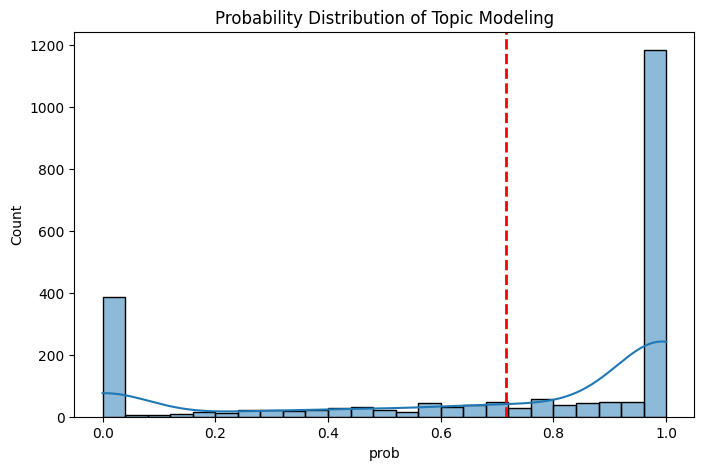

In [ ]:
# Plot distribution of probs
plt.figure(figsize=(8,5))
sns.histplot(splitted_data['prob'], bins=25, kde=True)
plt.axvline(splitted_data['prob'].mean(), color='r', linestyle='dashed', linewidth=2, label="Mean")
plt.title("Probability Distribution of Topic Modeling")

In [ ]:
splitted_data['prob'].describe()

count    2216.000000
mean        0.716025
std         0.387247
min         0.000000
25%         0.456494
50%         1.000000
75%         1.000000
max         1.000000
Name: prob, dtype: float64

In [ ]:
# Articles with bad accurate topic modeling
# len(splitted_data[splitted_data['prob']<0.5][['content','topic_name','prob']])

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_hierarchy(hierarchical_topics=topic_model.hierarchical_topics(splitted_data['content'].values))

100%|██████████| 185/185 [00:03<00:00, 46.44it/s]


In [ ]:
# Which words contribute most to our topics?
topic_model.visualize_barchart(width=300, height=300, n_words=10)

In [ ]:
# Save data as csv
splitted_data.to_csv('/content/drive/MyDrive/Colab Notebooks/Chezlong/Data/splitted_data_topics.csv', index=False)